<a href="https://colab.research.google.com/github/Haque14/MSE504/blob/main/Homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework 5** for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering. Instructor Sergei V. Kalinin



# Graphene data set

We start with the same graphene data set that we explored in class. Run the full analysis in the notebook below.

## Import

In [ ]:
# Download the dataset, Will explain what each file corresponds to later
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From (original): https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
From (redirected): https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon&confirm=t&uuid=343c90b6-a1dd-4e8a-b805-434290edbd7f
To: /content/3DStack13-1-dec.npy
100% 157M/157M [00:06<00:00, 24.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
100% 52.4M/52.4M [00:00<00:00, 61.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
100% 2.45M/2.45M [00:00<00:00, 48.0MB/s]


In [ ]:
# Installing AtomAI
# It will be used to split the image into local patches centered on atoms

!pip install atomai

In [ ]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
import cv2
import torch
import torch.nn as nn

import seaborn as sns
from scipy import stats

tt = torch.tensor

In [ ]:
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

## Visualization

For the ease of analysis, let's make the movie shorter

Text(0.5, 1.0, 'Atomic coordinates')

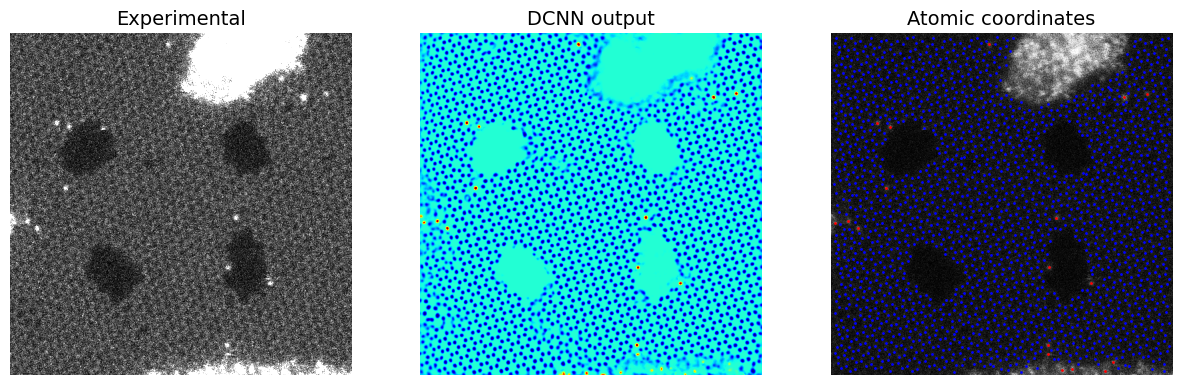

In [ ]:
#Vizualizing one frame of the data, we have 50 frames (0-49)

i = 3 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)

# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]

# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

## Creating features

In [ ]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below

window_size = 40   # Window_size

s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

In [ ]:
imstack = tt(s.imgstack[:,None,:,:, 0])
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

This code has created three objects. imstack is a collectrion of image patches of the size window_size. The object frames_all contain the information on the frame of the movie from which the image patch has come from. The object com_all contains the information on the coordinates of the patch (i.e. position of the atom that is its center) in the frame.

In [ ]:
imstack.shape, frames_all.shape, com_all.shape

(torch.Size([73995, 1, 40, 40]), (73995,), (73995, 2))

In [ ]:
np.unique(frames_all)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

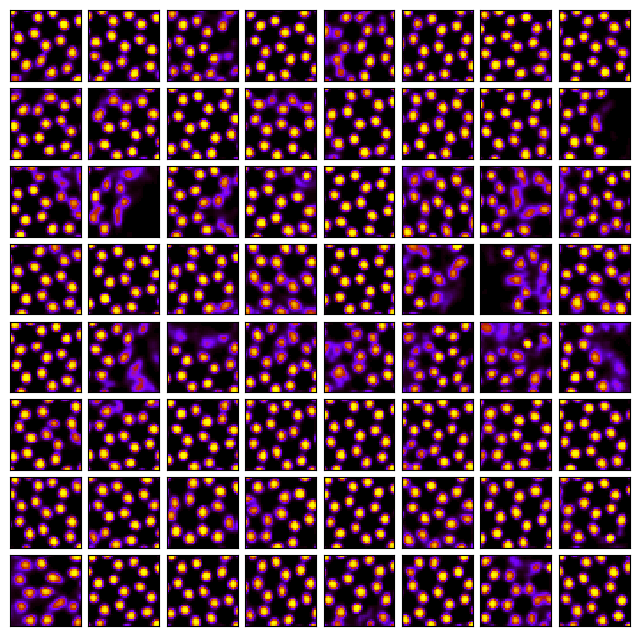

In [ ]:
# Vizualizing the training dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

# plt.savefig('example_imgs.png', dpi = 300)

We can check the sizes of all objects we have created

In [ ]:
imstack.shape

torch.Size([73995, 1, 40, 40])

Now, we can select the patches and coordinates corresponding only to the first frame.

In [ ]:
imstack1 = imstack[frames_all == 1]
com_all1 = com_all[frames_all == 1]
imstack1.shape, com_all1.shape

(torch.Size([1798, 1, 40, 40]), (1798, 2))

## k-means clustering

And run the k-means clustering

In [ ]:
from sklearn.cluster import KMeans

a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

nc = 3
km = KMeans(n_clusters=nc, random_state=0)
y_km = km.fit_predict(imstack2)

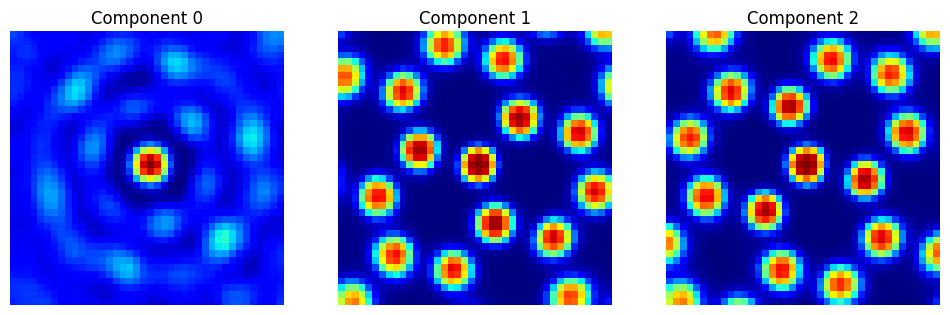

In [ ]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(km.cluster_centers_[i,:].reshape(c, d), cmap = 'jet', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

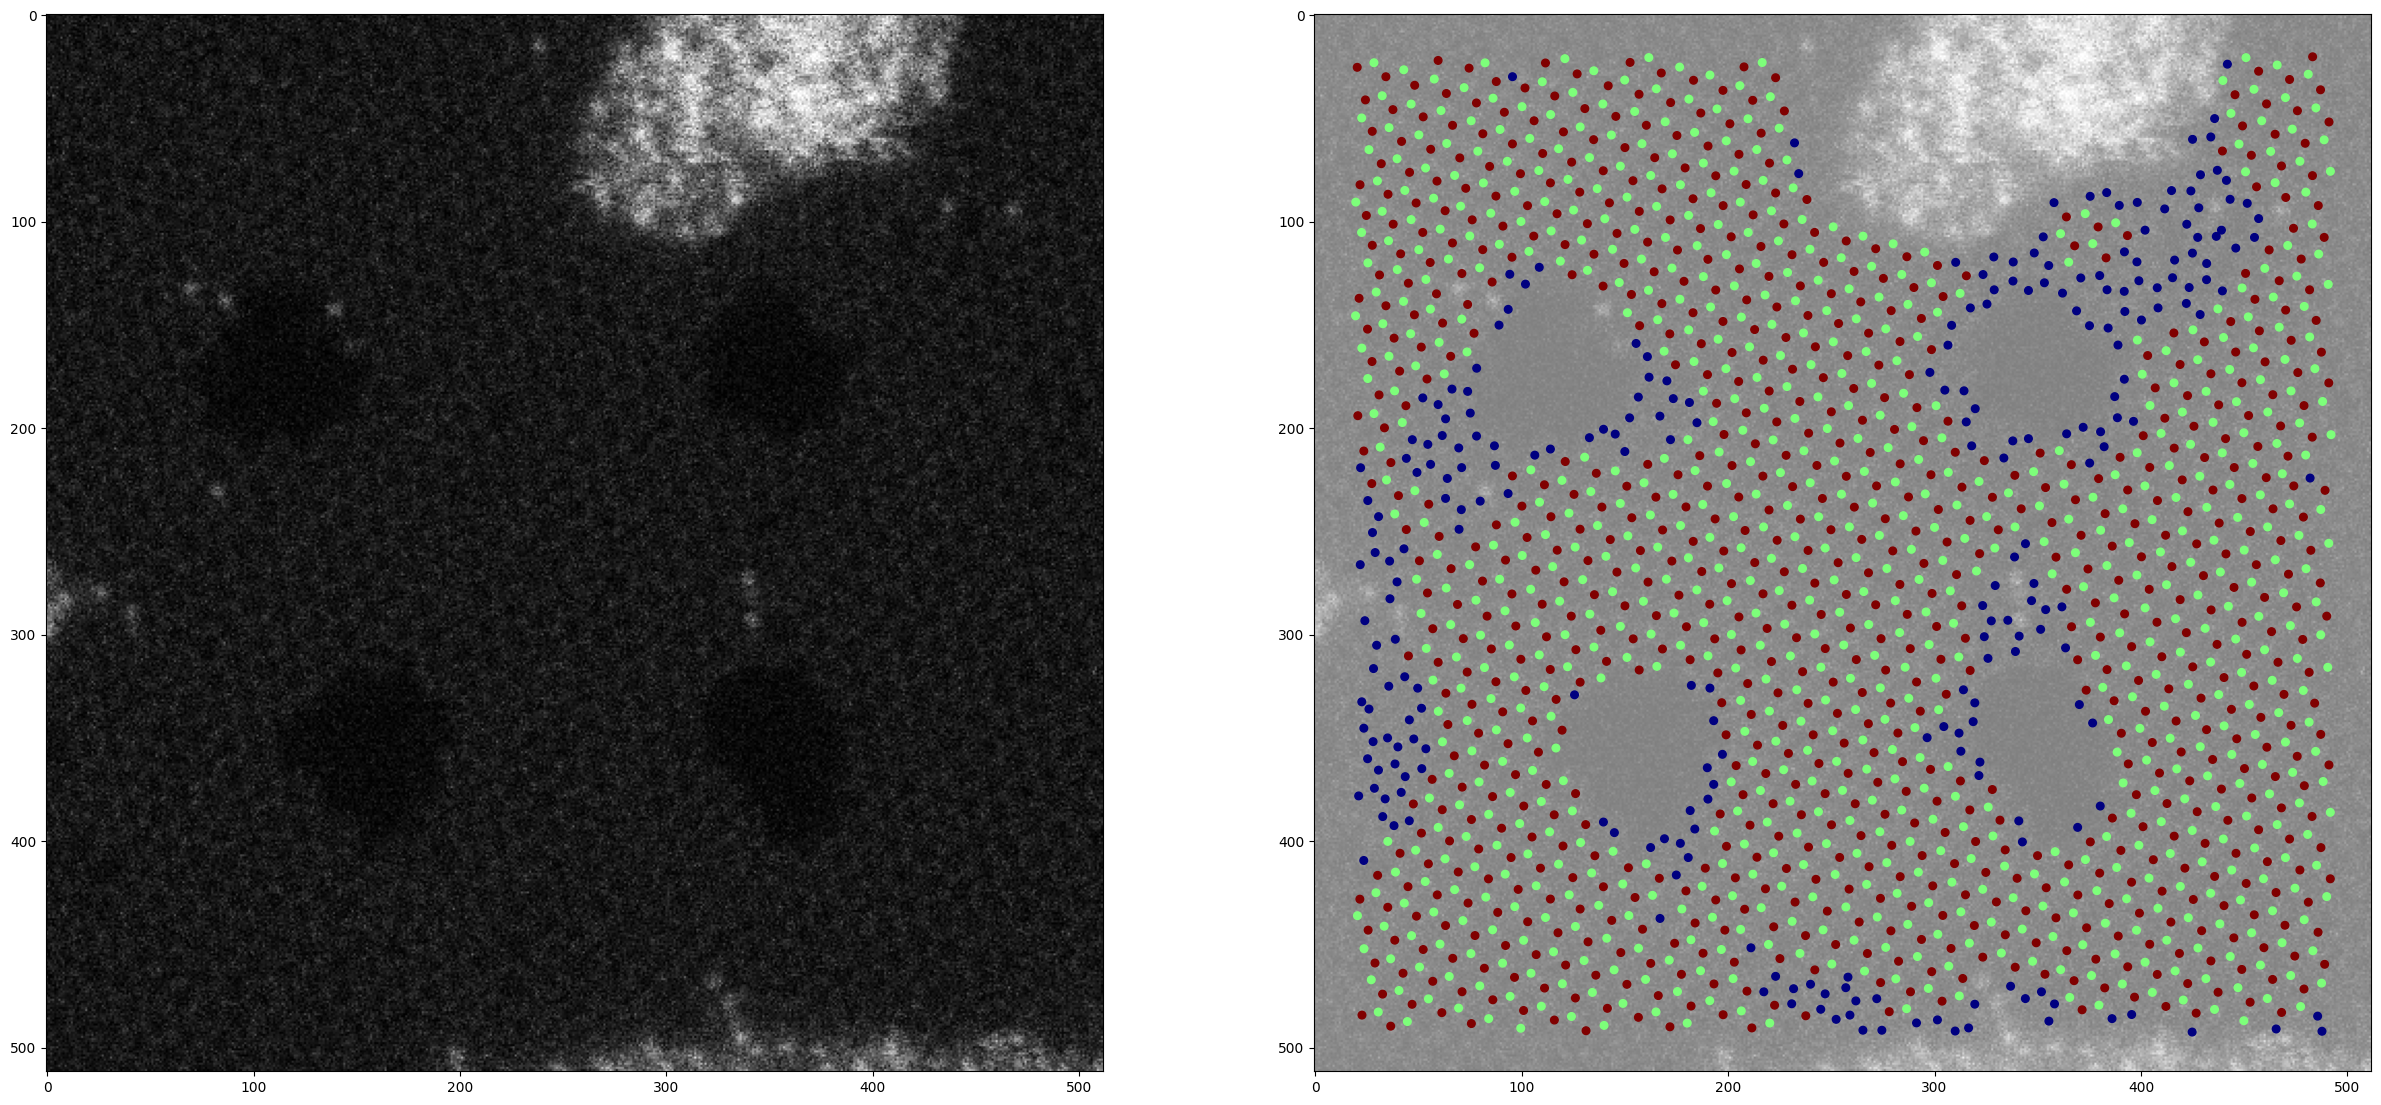

In [ ]:
#Visualizing the cluster labels on the raw STEM image

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

ax[0].imshow(STEM_real[i,...,0], cmap="gray")
ax[1].imshow(STEM_real[i,...,0], cmap="gray", alpha = 0.5)
ax[1].scatter(com_all1[:, 1], com_all1[:, 0], c=y_km, s=30, cmap="jet")

plt.show()

## GMM clustering

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

nc = 8
gmm = GMM(n_components=nc).fit(imstack2)
gr_labels = gmm.predict(imstack2)
gr_centers = gmm.means_

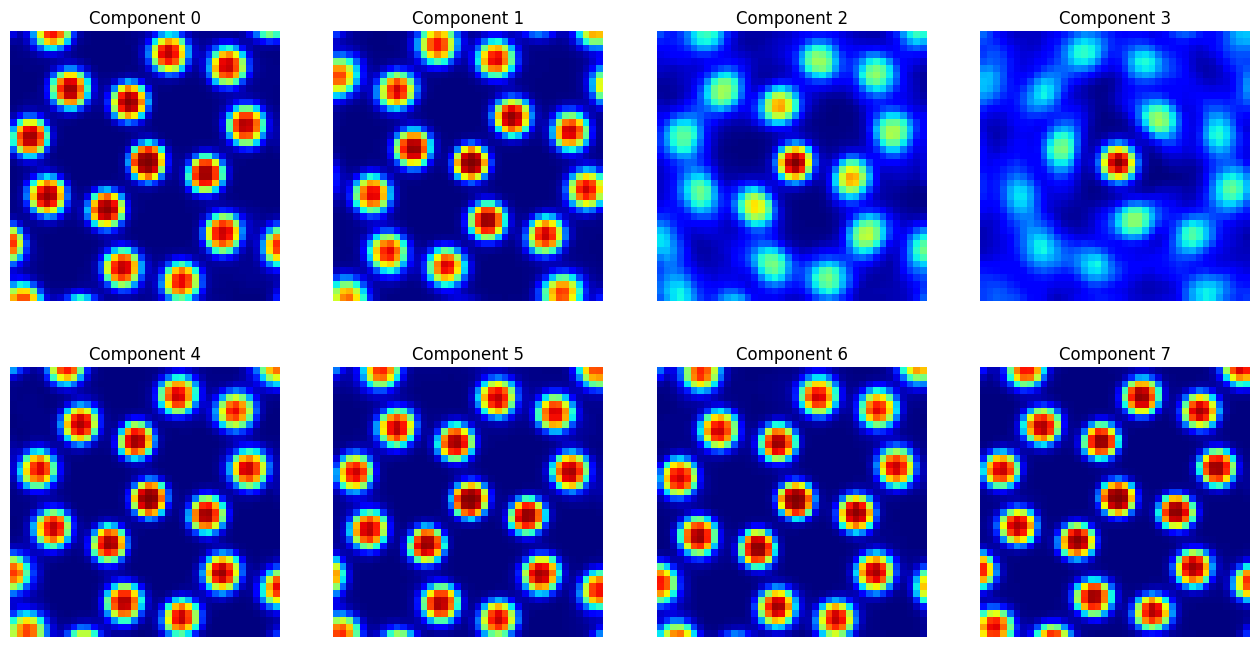

In [ ]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(gr_centers[i,:].reshape(c, d), cmap = 'jet', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

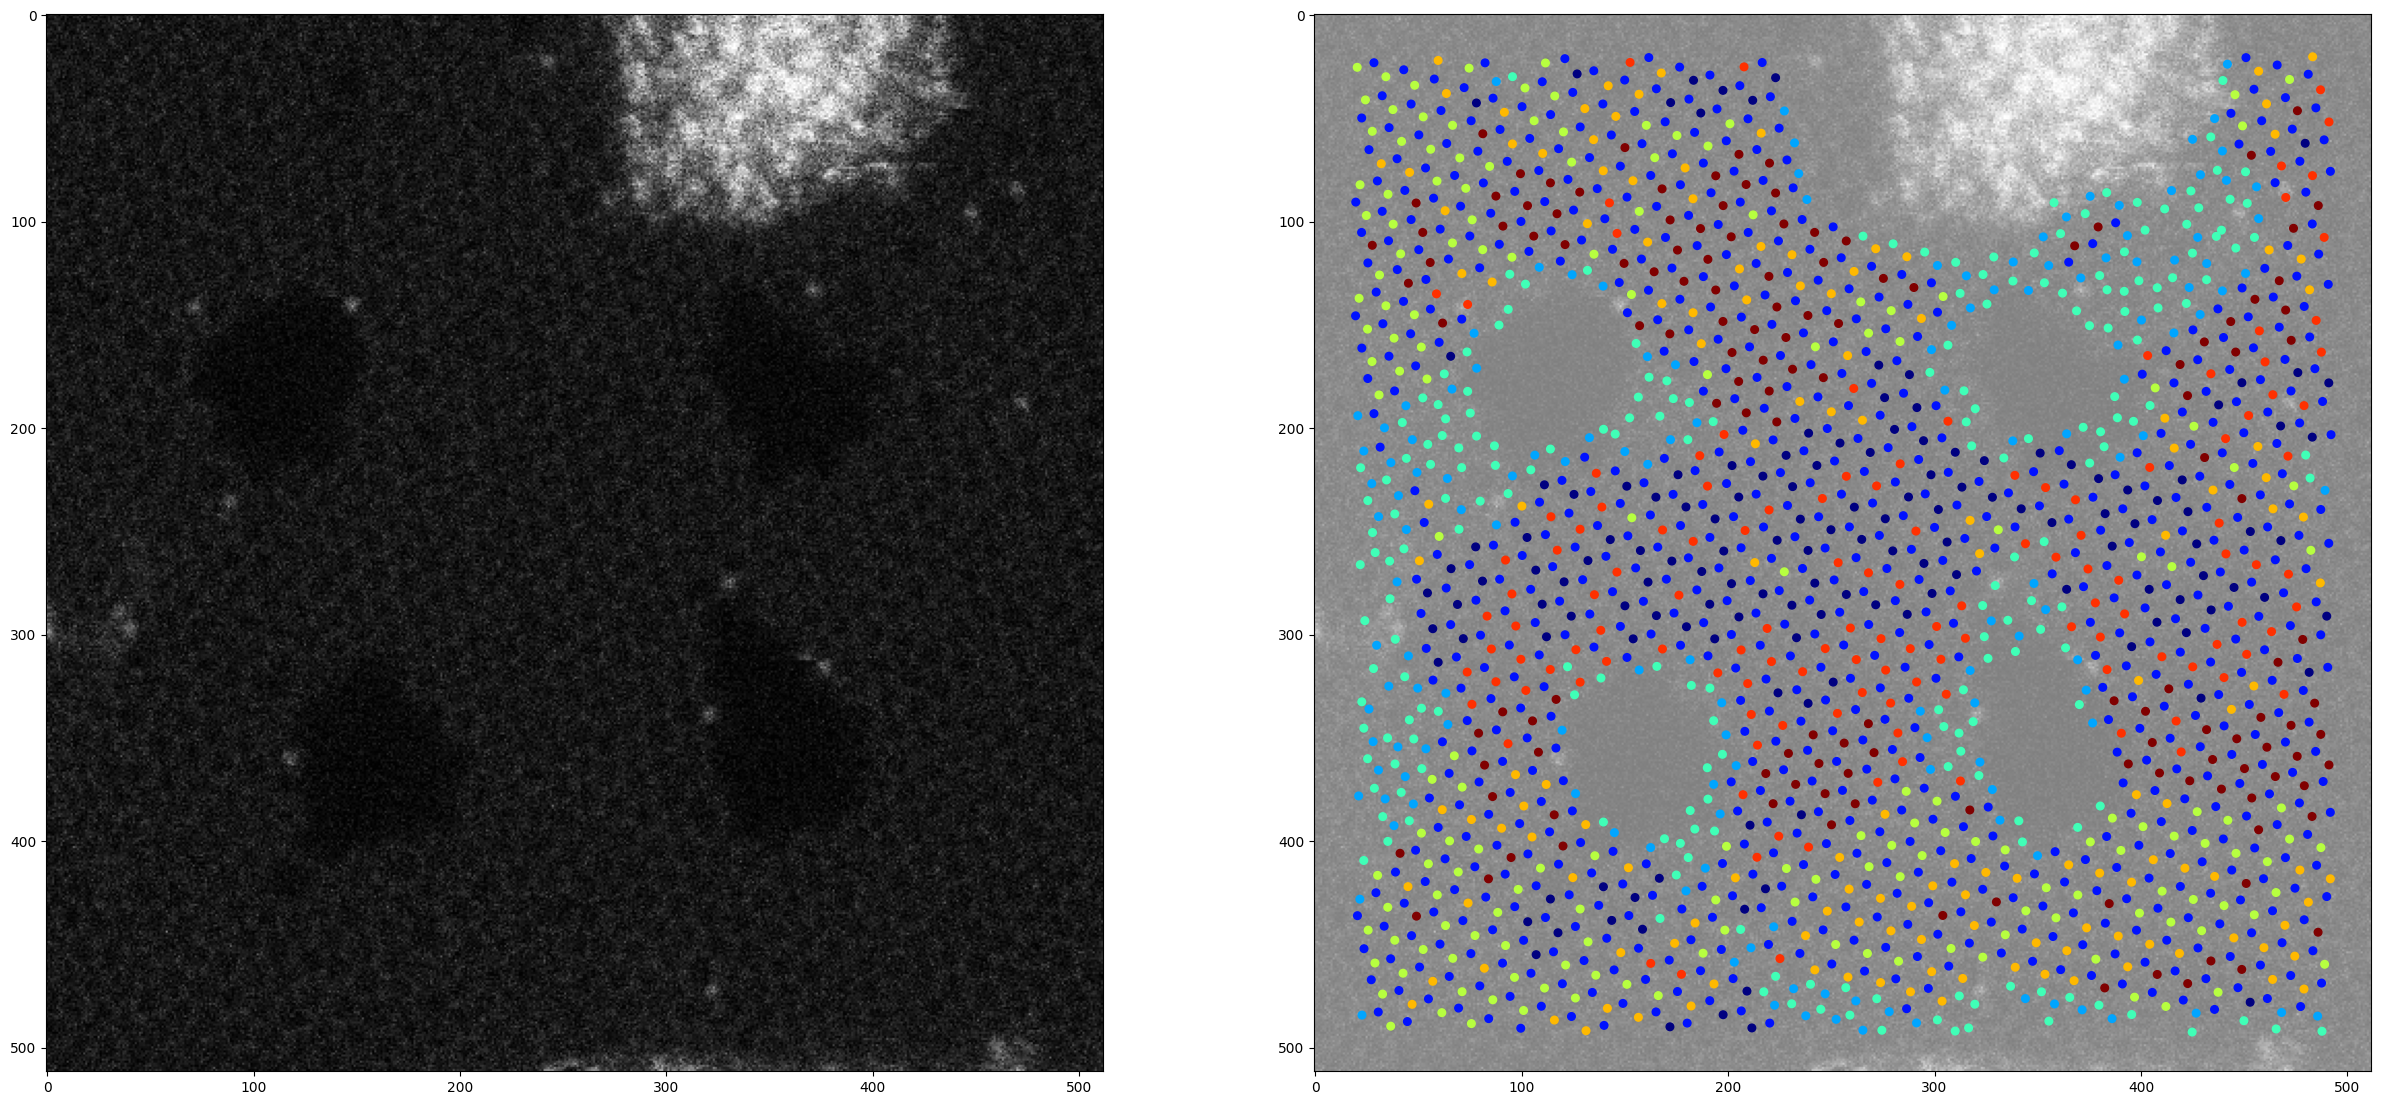

In [ ]:
#Visualizing the cluster labels on the raw STEM image

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

ax[0].imshow(STEM_real[i,...,0], cmap="gray")
ax[1].imshow(STEM_real[i,...,0], cmap="gray", alpha = 0.5)
ax[1].scatter(com_all1[:, 1], com_all1[:, 0], c=gr_labels, s=30, cmap="jet")

plt.show()

# General comment for homework

Below I provide a set of analyses for Homework 4 using the data above. However, please feel free:
- run this analysis on the EELS data set available in the Notebook 8_Clustering_EELS on https://github.com/SergeiVKalinin/MSE_Fall2023/blob/main/Module%203/8_Clustering_EELS.ipynb
- Or your own dataset as may be relevant to your research. The data set should allow for meaningful classification and clustering
- You can also use different data sets for the two
- use the !gdown method to import the dataset into colab from link (do not use the mounting GDrive option - since I will not be able to access it)

# Homework Part I

In [ ]:
!gdown https://github.com/SergeiVKalinin/MSE_Fall2023/blob/main/Module%203/8_Clustering_EELS.ipynb

Downloading...
From: https://github.com/SergeiVKalinin/MSE_Fall2023/blob/main/Module%203/8_Clustering_EELS.ipynb
To: /content/8_Clustering_EELS.ipynb
1.17MB [00:00, 19.8MB/s]


In [ ]:
# Installing AtomAI
# It will be used to split the image into local patches centered on atoms

!pip install atomai

1. Calculate the elbow curve for the k-means analysis above

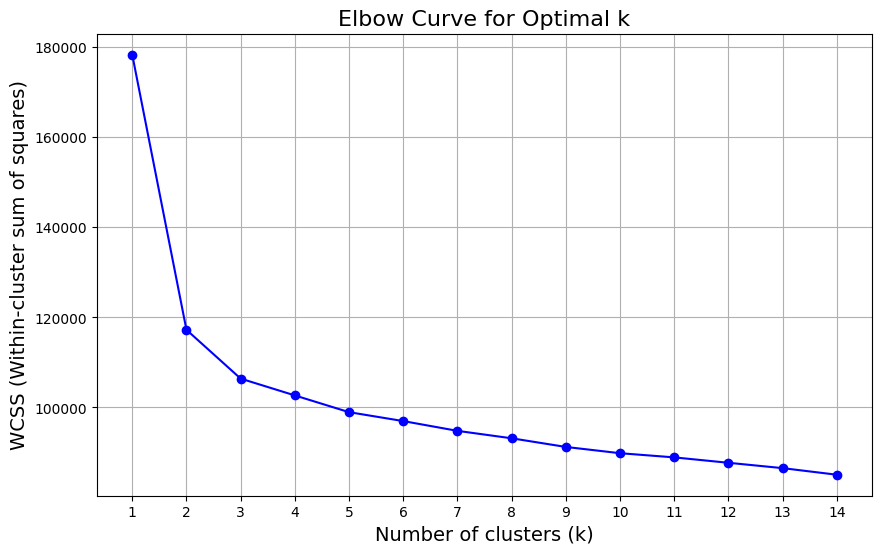

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Reshape imstack1 to 2D (samples, features)
a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

# Define the range of k values to try
k_values = range(1, 15)
wcss = []

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(imstack2)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of clusters (k)', fontsize=14)
plt.ylabel('WCSS (Within-cluster sum of squares)', fontsize=14)
plt.title('Elbow Curve for Optimal k', fontsize=16)
plt.xticks(k_values)
plt.grid(True)
plt.show()

2. Calculate the silhoutte for the k-means (or GMM - up to you)  for different number of clusters. Determine that optimal number of clusters for this data set and method.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Reshape imstack1 to 2D (samples, features)
a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

# Define the range of cluster numbers to evaluate
cluster_range = range(2, 15)  # Start from 2 since silhouette score is undefined for k=1
kmeans_silhouette_scores = []
gmm_silhouette_scores = []

# Evaluate K-Means
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans_labels = kmeans.fit_predict(imstack2)
    kmeans_silhouette_scores.append(silhouette_score(imstack2, kmeans_labels))

# Evaluate GMM
for k in cluster_range:
    gmm = GMM(n_components=k, random_state=0)
    gmm_labels = gmm.fit_predict(imstack2)
    gmm_silhouette_scores.append(silhouette_score(imstack2, gmm_labels))

# Plotting the Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, kmeans_silhouette_scores, 'bo-', label='K-Means Silhouette')
plt.plot(cluster_range, gmm_silhouette_scores, 'ro-', label='GMM Silhouette')
plt.xlabel('Number of clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Scores for K-Means and GMM', fontsize=16)
plt.xticks(cluster_range)
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal number of clusters for each method
optimal_kmeans_k = cluster_range[np.argmax(kmeans_silhouette_scores)]
optimal_gmm_k = cluster_range[np.argmax(gmm_silhouette_scores)]

print(f"Optimal number of clusters for K-Means: {optimal_kmeans_k}")
print(f"Optimal number of clusters for GMM: {optimal_gmm_k}")

3. Repeat this analysis for several wondow sizes (10, 20, 40, 60, 80). What is the optimal number of clusters for each of these window size? Rationalize these observations

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import atomai as aoi

# Define the window sizes to analyze
window_sizes = [10, 20, 40, 60, 80]

# Prepare to store results
optimal_kmeans_clusters = {}
optimal_gmm_clusters = {}

for window_size in window_sizes:
    print(f"Analyzing for window size: {window_size}")

    # Extract feature vectors using the current window size
    s = aoi.stat.imlocal(
        np.sum(decoded_imgs[..., :-1], -1)[..., None],
        lattice_coord,
        window_size, 0
    )

    # Convert to PyTorch tensor for processing
    imstack = torch.tensor(s.imgstack[:, None, :, :, 0])
    frames_all = s.imgstack_frames
    com_all = s.imgstack_com

    # Reshape imstack to 2D (samples, features)
    a, b, c, d = imstack.shape
    imstack2 = imstack.reshape(a, c * d)

    # Define the range of cluster numbers to evaluate
    cluster_range = range(2, 15)
    kmeans_silhouette_scores = []
    gmm_silhouette_scores = []

    # Evaluate K-Means
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans_labels = kmeans.fit_predict(imstack2)
        kmeans_silhouette_scores.append(silhouette_score(imstack2, kmeans_labels))

    # Evaluate GMM
    for k in cluster_range:
        gmm = GMM(n_components=k, random_state=0)
        gmm_labels = gmm.fit_predict(imstack2)
        gmm_silhouette_scores.append(silhouette_score(imstack2, gmm_labels))

    # Determine the optimal number of clusters for each method
    optimal_kmeans_k = cluster_range[np.argmax(kmeans_silhouette_scores)]
    optimal_gmm_k = cluster_range[np.argmax(gmm_silhouette_scores)]

    optimal_kmeans_clusters[window_size] = optimal_kmeans_k
    optimal_gmm_clusters[window_size] = optimal_gmm_k

    print(f"Optimal number of clusters for K-Means at window size {window_size}: {optimal_kmeans_k}")
    print(f"Optimal number of clusters for GMM at window size {window_size}: {optimal_gmm_k}\n")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(window_sizes, [optimal_kmeans_clusters[w] for w in window_sizes], 'bo-', label='K-Means')
plt.plot(window_sizes, [optimal_gmm_clusters[w] for w in window_sizes], 'ro-', label='GMM')
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('Optimal Number of Clusters', fontsize=14)
plt.title('Optimal Number of Clusters vs. Window Size', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'atomai'

Answer 3:

# **Rationale and Observations:**

**Smaller Window Sizes (10, 20):**

Smaller window sizes might capture more localized features and result in a higher number of optimal clusters because the sub-images will have more fine-grained, varied details. Consequently, the model might need more clusters to adequately represent the variability in these small windows.

**Moderate Window Sizes (40):**

A moderate window size might balance the level of detail and context in each sub-image. This could lead to a middle-ground number of optimal clusters, capturing essential patterns without overfitting to fine details.

**Larger Window Sizes (60, 80):**

Larger windows include more context and might capture broader patterns or repetitive structures. This might reduce the need for many clusters, as the larger windows could smooth out local variations, leading to a lower number of optimal clusters.

# **Potential Outcomes:**

You might observe that the optimal number of clusters decreases as the window size increases, reflecting the transition from detailed, localized patterns to broader, more generalized structures.
The difference between the optimal numbers for K-Means and GMM could give insight into whether the clusters are more spherical (K-Means) or ellipsoidal (GMM).

# **Practical Implications:**

**Choosing a Window Size:** Depending on the objective (e.g., identifying fine details or broader patterns), you might choose different window sizes.

**Clustering Approach:** The choice between K-Means and GMM might depend on how well-defined and distinct the clusters are, as indicated by the silhouette scores.

4. In class, we have explored the density based clustering tehcniques. Following the GMM and k-means clustering analysis above, run the same analysis using the density based clustering.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import atomai as aoi

# Define the window sizes to analyze
window_sizes = [10, 20, 40, 60, 80]

# Prepare to store results
dbscan_silhouette_scores = {}
optimal_eps_values = {}

# Define range of eps values to try
eps_values = np.linspace(0.1, 1.5, 15)

for window_size in window_sizes:
    print(f"Analyzing for window size: {window_size}")

    # Extract feature vectors using the current window size
    s = aoi.stat.imlocal(
        np.sum(decoded_imgs[..., :-1], -1)[..., None],
        lattice_coord,
        window_size, 0
    )

    # Convert to PyTorch tensor for processing
    imstack = torch.tensor(s.imgstack[:, None, :, :, 0])
    frames_all = s.imgstack_frames
    com_all = s.imgstack_com

    # Reshape imstack to 2D (samples, features)
    a, b, c, d = imstack.shape
    imstack2 = imstack.reshape(a, c * d)

    # Evaluate DBSCAN with different eps values
    best_silhouette = -1
    best_eps = None

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        db_labels = dbscan.fit_predict(imstack2)

        # Calculate silhouette score if more than one cluster is found
        if len(set(db_labels)) > 1 and -1 not in db_labels:
            silhouette = silhouette_score(imstack2, db_labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps

    dbscan_silhouette_scores[window_size] = best_silhouette
    optimal_eps_values[window_size] = best_eps

    print(f"Best silhouette score for DBSCAN at window size {window_size}: {best_silhouette}")
    print(f"Optimal eps for DBSCAN at window size {window_size}: {best_eps}\n")

# Plotting the Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(window_sizes, [dbscan_silhouette_scores[w] for w in window_sizes], 'go-', label='DBSCAN Silhouette')
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('DBSCAN Silhouette Scores vs. Window Size', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

5. When exploring the analysis for window_size = 40, you will note that symmetry non-equivalent carbon atoms in sp2 configuration are classified into different groups. However, chemically these are equivalent. Suggest potential approach to avoid this problem.

Answer 5:

# **Potential Approaches to Address the Problem:**

**1.   Feature Engineering: Incorporate Symmetry Information**


*      **Symmetry-Aware Features:** Modify the feature vectors to explicitly incorporate symmetry information. For instance, you could calculate symmetry-adapted descriptors (e.g., rotationally invariant descriptors, bond angles, or distances to neighboring atoms) that are less sensitive to small variations in the local environment.
*      **Average over Symmetry-Related Positions:** For each atom, you could average the features over all symmetry-related positions before applying the clustering algorithm. This way, symmetry-equivalent atoms will have the same feature vector and be more likely to be classified into the same group.

**2.   Post-Processing Clusters with Symmetry Constraints**


*   **Cluster Merging Based on Symmetry:** After clustering, identify groups that correspond to symmetry-equivalent atoms and merge them. For example, if clustering separates symmetry-equivalent atoms into different groups, you could calculate the symmetry equivalence of the resulting clusters and merge clusters that correspond to the same chemical environment.
*   **Symmetry-Based Reassignment:** After initial clustering, reassign atoms that are chemically equivalent but classified into different groups based on their chemical symmetry. This could involve a second pass where atoms are reclassified based on their proximity to the cluster centers of symmetry-equivalent atoms.


**3.   Supervised or Semi-Supervised Learning**


*   **Labeling Symmetry-Equivalent Atoms:** If you have prior knowledge of which atoms are symmetry-equivalent, you could label these atoms accordingly and use this information in a supervised or semi-supervised clustering algorithm. This would ensure that symmetry-equivalent atoms are grouped together.
*   **Constraint-Based Clustering:** Use a clustering algorithm that allows incorporating constraints. For example, using a semi-supervised clustering algorithm like Constrained K-Means, you could specify that certain points (symmetry-equivalent atoms) must belong to the same cluster.

**4.  Data Augmentation**


*   **Augment Data with Symmetry Operations:** Generate additional data points by applying symmetry operations (e.g., rotations, reflections) to your existing data. Then, train your clustering algorithm on this augmented dataset. This can help the algorithm learn the symmetry-invariant properties of the atoms, leading to more consistent classification of symmetry-equivalent atoms.

**5.  Dimensionality Reduction with Symmetry-Preserving Techniques**

*  **Symmetry-Preserving PCA:** Use a dimensionality reduction technique like Principal Component Analysis (PCA) that can be modified to preserve symmetry properties. By projecting data into a lower-dimensional space where symmetry-related features are emphasized, clustering in this space might result in symmetry-equivalent atoms being grouped together.



6 (Optional - if well familiar with Python and want a challenge). Realize this approach

In [ ]:
import numpy as np

# Example of modifying feature vectors to incorporate rotational invariance
def rotational_invariant_features(features):
    # Calculate rotationally invariant features (e.g., distances, angles)
    # This is a simplified example; actual implementation would depend on the system's symmetry
    invariant_features = np.zeros(features.shape)

    # Example: calculate distances between atoms, which are rotationally invariant
    for i in range(features.shape[0]):
        for j in range(features.shape[1]):
            invariant_features[i, j] = np.linalg.norm(features[i] - features[j])

    return invariant_features

# Apply this to your feature vectors before clustering
invariant_imstack = rotational_invariant_features(imstack2)

# Now apply clustering on invariant_imstack instead of imstack2

7. (Optional - if well familiar with Python and want a challenge). Analyze the stack of images using k-means clustering and plot the evolution of cluster fractions as a function of time.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume imstack contains your image stack with shape (frames, channels, height, width)
frames, channels, height, width = imstack.shape

# Reshape each frame to 2D (samples, features)
imstack_reshaped = imstack.reshape(frames, channels * height * width)

# Set the number of clusters
n_clusters = 5  # Adjust as needed

# Initialize list to store cluster fractions for each frame
cluster_fractions = np.zeros((frames, n_clusters))

# Apply K-Means clustering on each frame and calculate cluster fractions
for i in range(frames):
    # Apply K-Means to the current frame
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(imstack_reshaped[i].reshape(-1, channels))

    # Get the labels for each pixel
    labels = kmeans.labels_

    # Calculate the fraction of each cluster in the current frame
    for j in range(n_clusters):
        cluster_fractions[i, j] = np.sum(labels == j) / len(labels)

# Plot the evolution of cluster fractions over time
time_points = np.arange(frames)
plt.figure(figsize=(10, 6))

for j in range(n_clusters):
    plt.plot(time_points, cluster_fractions[:, j], label=f'Cluster {j+1}')

plt.xlabel('Time (frames)', fontsize=14)
plt.ylabel('Cluster Fraction', fontsize=14)
plt.title('Evolution of Cluster Fractions Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Homework Part II

After running the analysis in the previous sections, we now have access to the k-means clustering results of the image patches. Effectively, each atom in the image is now associated with the patch centered on this atom, and the cluster label. The y_km is a label array, and km.cluster_centers_ is the centroid of the clustes. Remember that you need to reshape it back to (window_size, window_size) in order to get the image. We also have access to the imstack2 object, which is a collection of all patches, and com_all1 object that contains the information on the coordinate from which the patch has come from.

In [ ]:
y_km.shape, km.cluster_centers_.shape, imstack2.shape, com_all1.shape

((1798,), (3, 1600), torch.Size([1798, 1600]), (1798, 2))

8. Create a X,y data set for a classification problem. Here, the image is a feature, and the cluster label is assumed to be known ground truth label (alternatively, we can do manual labelling, but for the purpose of excercise let's assume that ground truth labels are already known).

In [ ]:
import numpy as np

# Assuming the following variables are defined:
# imstack2: The collection of all patches (flattened), shape (n_patches, window_size * window_size)
# y_km: Array of cluster labels (ground truth labels), shape (n_patches,)

# X will be the imstack2 array
X = imstack2  # (n_patches, window_size * window_size)

# y will be the cluster labels
y = y_km  # (n_patches,)

# Optional: Print the shapes to verify
print("X shape:", X.shape)  # Should be (n_patches, window_size * window_size)
print("y shape:", y.shape)  # Should be (n_patches,)

9. Use the train_test_split function to create the training set and test set for classification problem.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assumed Variables:
# - imstack2: (n_patches, window_size * window_size) -> Flattened patches
# - y_km: (n_patches,) -> Cluster labels corresponding to each patch
# - window_size: The size of the window used to create patches

# Step 1: Prepare the dataset (X, y)
# X will be the feature matrix (image patches)
X = imstack2  # (n_patches, window_size * window_size)

# y will be the label vector (cluster labels)
y = y_km  # (n_patches,)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes to verify
print("X_train shape:", X_train.shape)  # e.g., (800, 1600) if 1000 patches, 40x40 window
print("X_test shape:", X_test.shape)    # e.g., (200, 1600)
print("y_train shape:", y_train.shape)  # e.g., (800,)
print("y_test shape:", y_test.shape)    # e.g., (200,)

# Step 3: Train a classifier (Random Forest in this case)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = clf.predict(X_test)

# Step 5: Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

# Optional: Visualize the feature importance
feature_importances = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

10. Run the logistics classification on the data and plot the confucion matrix and ROC curve

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assumed Variables:
# - imstack2: (n_patches, window_size * window_size) -> Flattened patches
# - y_km: (n_patches,) -> Cluster labels corresponding to each patch
# - window_size: The size of the window used to create patches

# Step 1: Prepare the dataset (X, y)
X = imstack2  # (n_patches, window_size * window_size)
y = y_km      # (n_patches,)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a logistic regression classifier
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)

# Step 5: Evaluate the classifier's performance with a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 6: ROC Curve and AUC
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Optional: Print a detailed classification report
print(classification_report(y_test, y_pred))

11. Run the CART classification on the data and plot the decision tree and ROC curve. Is this analysis meaningful?

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assumed Variables:
# - imstack2: (n_patches, window_size * window_size) -> Flattened patches
# - y_km: (n_patches,) -> Cluster labels corresponding to each patch
# - window_size: The size of the window used to create patches

# Step 1: Prepare the dataset (X, y)
X = imstack2  # (n_patches, window_size * window_size)
y = y_km      # (n_patches,)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Decision Tree (CART) classifier
cart = DecisionTreeClassifier(random_state=42)
cart.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = cart.predict(X_test)
y_pred_proba = cart.predict_proba(X_test)

# Step 5: Evaluate the classifier's performance with a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 6: ROC Curve and AUC
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 7: Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(cart, filled=True, feature_names=[f'pixel_{i}' for i in range(X_train.shape[1])], class_names=[str(i) for i in np.unique(y)], rounded=True)
plt.title("Decision Tree (CART) Visualization")
plt.show()

# Optional: Print a detailed classification report
print(classification_report(y_test, y_pred))

Answer 11:

The meaningfulness of the analysis you've conducted depends on several factors, including the nature of your data, the assumptions behind the algorithms you're using, and the specific goals of your analysis. Let's break down some key considerations to determine if the analysis is appropriate and meaningful:

# **1. Nature of the Data:**

Patch-Based Analysis: You've treated each image patch as a separate data point, which is reasonable if the patches represent distinct features or atomic environments. However, it's important to consider whether the patches are truly independent. If neighboring patches are highly correlated, this could affect the clustering and classification results.
Cluster Labels as Ground Truth: The cluster labels (y_km) derived from K-Means are being treated as ground truth for classification. This is a common approach when manually labeling data isn't feasible, but it's important to remember that K-Means clusters are based on distance in feature space and may not correspond to meaningful physical or chemical properties. The classifier will simply learn to replicate the clustering rather than learning an underlying physical property.
2. Algorithm Choice:
CART Decision Trees: Decision trees are interpretable models that make decisions based on simple if-then rules. They are well-suited for data where you can identify clear decision boundaries. However, decision trees can overfit, especially with high-dimensional data (like image patches) unless regularized properly (e.g., limiting tree depth).
ROC Curves and AUC: ROC curves and AUC are useful for evaluating classifier performance, especially in binary or multi-class classification problems. However, in multi-class scenarios, the interpretation of ROC curves can be less straightforward. If your clusters/classes are not well-separated or meaningful, the ROC analysis might not provide significant insights.
3. Goal of the Analysis:
Understanding Atomic Environments: If the goal is to understand different atomic environments or patterns in your images, clustering followed by classification could be meaningful. However, it's essential to validate that the clusters truly represent distinct physical or chemical environments. If not, the classification results might not have real-world significance.
Interpretability: The decision tree visualization can be insightful, especially if the decision nodes correspond to interpretable features (e.g., specific pixel intensities or patterns). However, if the tree is too complex or the features aren't meaningful, the interpretation might be challenging.
4. Potential Issues:
Overfitting: Decision trees are prone to overfitting, especially with noisy or high-dimensional data like image patches. Overfitting means the model might perform well on the training data but poorly on unseen data, capturing noise rather than true signal.
Cluster Validity: The validity of treating K-Means clusters as ground truth labels should be questioned. If the clusters don't correspond to meaningful differences in the data, the classification task becomes circular—essentially learning to reproduce the clustering rather than uncovering new insights.
Recommendations:
Validation of Clusters: Before treating cluster labels as ground truth, consider validating the clusters. For example, you could manually inspect cluster centroids or compare clusters to known physical or chemical properties if available.
Dimensionality Reduction: If the data is very high-dimensional (e.g., large patches), consider applying dimensionality reduction (e.g., PCA) before clustering or classification to reduce noise and improve interpretability.
Regularization: To prevent overfitting in decision trees, apply regularization techniques such as limiting the maximum depth of the tree, setting a minimum number of samples per leaf node, or using pruning.
Alternative Approaches: Depending on your goals, alternative methods such as Support Vector Machines (SVM), Random Forests, or Convolutional Neural Networks (CNNs) might offer better performance or interpretability, especially for image data.

12. Run the XGBoost classification on the dataset and plot the ROC curve.

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assumed Variables:
# - imstack2: (n_patches, window_size * window_size) -> Flattened patches
# - y_km: (n_patches,) -> Cluster labels corresponding to each patch
# - window_size: The size of the window used to create patches

# Step 1: Prepare the dataset (X, y)
X = imstack2  # (n_patches, window_size * window_size)
y = y_km      # (n_patches,)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# Step 5: Evaluate the classifier's performance with a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 6: ROC Curve and AUC
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Optional: Print a detailed classification report
print(classification_report(y_test, y_pred))